# The evolution of the language in films

In [17]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pyspark.sql.types import *
import pyspark.sql.functions as F

import findspark
findspark.init()

from pyspark.sql import *
%matplotlib inline

spark = SparkSession.builder.getOrCreate()
#sqlContext = SQLContext(sc)

## 0. Extraction of data

Each subtitle in the OpenSubtitle database is stored in a seperate XML-file. In order to analyse the data and calculate our descriptive statistics we need to convert it to a format supported by Spark/Pandas. 

In order to process the dataset using spark, we will use the spark-xml package from databricks (https://github.com/databricks/spark-xml). When using spark-xml, you can either let spark-xml infer the schema of the XML file or you can specify it yourself. Delegating the job of creating the schema to spark-xml is convenient however it is very expensive which we experienced through first hand experience. In order to speed up our input pipeline, we will specify or own static xml schema below. When specifying the schema yourself, spark-xml will not try to infer the schema which gives a significant performance boost.

### 0.1. schema

We will use two different schemas, one schema will be used to extract the movie meta data contained in each subtitle file and the other schema will be used to extract the actual subtitle text.

**XML Schema for meta data extracting:**

In [57]:
# Schema for the source XML-tag
sourceSchema = StructType([\
                            StructField('genre', StringType()),
                            StructField('year', StringType()),
                          ])

# Schema for the source XML-tag
subtitleSchema = StructType([\
                            StructField('duration', StringType())
                          ])

# Schema for the conversion XML-tag
conversionSchema =  StructType([\
                                StructField('sentences', StringType()),
                                StructField('tokens', StringType())
                              ])

# Schema for the meta XML-tag
mSchema = StructType([\
                        StructField('source', sourceSchema),
                        StructField('conversion', conversionSchema),
                        StructField('subtitle', subtitleSchema),
                    ])

# Root schema
metaSchema = StructType([
    StructField('_id', IntegerType()),
    StructField('meta', mSchema)
])

**XML Schema for subtitle data extracting:**

What we will end up with is a dataframe with a column called **s** which is of type Array. The elements of the Array in column **s** holds elements which also are arrays. Each nested array represents a sentnce and each element of the nested Arrays are the words of the sentence.

In [58]:
# Schema for the w (word) XML-tag
wordSchema = ArrayType(StructType([\
                                StructField('_VALUE', StringType())\
                               ]))

# Schema for the s (sentence) XML-tag
sentenceSchema = StructType([StructField('w', wordSchema)])

# Root schema
sentenceSchema = StructType([
    StructField('_id', IntegerType()),
    StructField('s', ArrayType(sentenceSchema))
])

### 0.2 Parsing of xml-data

The subtitles are stored in folders in the following structure:

**opensubtitle/OpenSubtitles2018/xml/ { language } / { year } / { imdb_id } / { openSubtitle_id }.xml.gz**

* year is the release year of the movie
* langauge is the language of the movie
* imdb_id: id of the movie in the IMDB database
* openSubtitle_id: unique identifier in the opensubtitle database

With the help of regular expression we can load every single subtitle file at once. 

In [59]:
# Loads all subtitles files in english and parses the input files with the schema for meta data.
df = sqlContext.read.format('com.databricks.spark.xml')\
    .options(rowTag='document', samplingRatio=0.0)\
    .load('[0-9][0-9][0-9][0-9]/**/*.xml.gz', schema=metaSchema)
    #.load('hdfs:///datasets/opensubtitle/OpenSubtitles2018/xml/en/[0-9]{4}/**/*.xml.gz', schema=metaSchema)

**The meta data we extract for each movie is the following:**

* _id: the openSubtitle id
* year: the release year of the movie
* sentences: the total amount of sentences in the movie
* words: the total amount of words in the movie (not unique words)
* duration: the duration of the movie
* imdb_id: id of the movie in the IMDB database

The imdb_id is actually not contained in the XML-file of each movie but the parent directory of each XML subtitle file is named using the imdb identifier. Therefore, we extract the imdb_id from the file path of each subtitle file.

In [60]:
movies = df.select(\
               F.col("_id"),\
               F.col("meta.source.genre").alias("genre"),\
               F.col("meta.source.year").alias("year"),\
               F.col("meta.conversion.sentences").alias("sentences"),\
               F.col("meta.conversion.tokens").alias("words"),\
               F.col("meta.subtitle.duration").alias("duration"))  

movies = movies.withColumn("imdb_id",F.split(F.input_file_name(), "/").getItem(6))

In [ ]:
movies.write.mode("overwrite").parquet('movie_data_with_imdb_id.parquet')

### 0.3 Enriching the dataset

With the help of the imdb_id, we can enrich our dataset with one or several of IMDBs public datasets (https://www.imdb.com/interfaces/). We are interested in the imdb rating of each movie, let's add it to our existing movies dataframe by joining it with the ratings dataset of IMDB.

In [63]:
movies = spark.read.parquet("./movie_data_with_imdb_id.parquet")
movies.show(5)

+-------+--------------------+----+---------+-----+------------+-------+
|    _id|               genre|year|sentences|words|    duration|imdb_id|
+-------+--------------------+----+---------+-----+------------+-------+
|7018237|Comedy,Drama,Romance|1947|     2768|20350|01:55:25,969|  39477|
|3528271| Crime,Drama,Fantasy|1993|     1557|10885|01:56:41,202| 107665|
|4655639|Animation,Comedy,...|1935|      142|  457|00:15:15,010|  26706|
|4336532|Adventure,Crime,D...|1964|      906| 6723|00:50:21,667| 583992|
|3452622|Crime,Mystery,Thr...|1922|      630| 7016|03:54:14,811|  13086|
+-------+--------------------+----+---------+-----+------------+-------+
only showing top 5 rows



In [64]:
imdb_ratings = spark.read.format("csv")\
                        .option("header", "true")\
                        .option("sep", "\t").load("title.ratings.tsv")
imdb_ratings.show(5)

+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt0000001|          5.8|    1437|
|tt0000002|          6.3|     171|
|tt0000003|          6.6|    1037|
|tt0000004|          6.4|     102|
|tt0000005|          6.2|    1734|
+---------+-------------+--------+
only showing top 5 rows



For some unknown reason, the imdb id's in the imdb_ratings dataframe are prefixed with the string "tt". We need to get rid of the prefix in order to join the imdb_ratings dataframe with our movies dataframe.

In [65]:
remove_prefix = F.udf(lambda x: x[2:], StringType())
imdb_ratings = imdb_ratings.select('averageRating', 
                                   'numVotes', 
                                   remove_prefix(F.col('tconst')).alias('_id'))
# we do a left outer join since we still want to keep movies from our original dataset that 
# does not match any movies in the imdb dataset.
movies = movies.join(imdb_ratings, movies.imdb_id == imdb_ratings._id, "left_outer")

In [ ]:
movies.write.mode("overwrite").parquet('movie_data_enriched.parquet')

## 1. Descriptive statistics

Before working with our data, let's get to know it. We will start by getting the movie data.

In [2]:
movies = spark.read.parquet("./movie_data.parquet")
print("There are " + str(movies.count()) + " movies in the dataset.")

There are 177036 movies in the dataset.


What information do we have for every movie?

In [3]:
movies.schema

StructType(List(StructField(_id,IntegerType,true),StructField(genre,StringType,true),StructField(year,StringType,true),StructField(sentences,StringType,true),StructField(words,StringType,true),StructField(duration,StringType,true)))

In [4]:
movies = movies.toDF('id', 'genre', 'year', 'sentences', 'words', 'duration')
movies.printSchema()

root
 |-- id: integer (nullable = true)
 |-- genre: string (nullable = true)
 |-- year: string (nullable = true)
 |-- sentences: string (nullable = true)
 |-- words: string (nullable = true)
 |-- duration: string (nullable = true)



### 1.1 Number of movies by year

So how many movies are there for each year? We presume there will be more movies in recent years than 1950. 

Firstly, we check the range of the years.

In [5]:
movies.describe('year').show()

+-------+------------------+
|summary|              year|
+-------+------------------+
|  count|            175488|
|   mean|2002.3560762849568|
| stddev|18.338728088971912|
|    min|              1906|
|    max|              2020|
+-------+------------------+



Now let's draw a chart showing exactly how many movies were there for each year.

In [6]:
# get movie counts per year
movies_per_year = movies.groupby('year').count()

# convert to Pandas for plotting
ydf = movies_per_year.toPandas()

# sort the films by year
ydf = ydf.sort_values(by='year')

We need to clean our data of null values and inconsistent entries.

In [7]:
n_before = sum(ydf['count'])
print("Before cleaning we have " + str(n_before) + " films. ")

# convert year to int the 'year' value
ydf['year'] = pd.to_numeric(ydf['year'], errors='coerce', downcast='integer')

# remove films with "Nan" as year value
# since we cannot really use them
ydf = ydf.dropna()
ydf = ydf.reset_index(drop=True)
ydf['year'] = ydf['year'].astype('int')

n_after = sum(ydf['count'])
print("After cleaning we have " + str(n_after) + " films. ")
print("Only %.2f%% of our dataset was invalid/inconsistent." % (1 - (n_after/n_before)))

Before cleaning we have 177036 films. 
After cleaning we have 175395 films. 
Only 0.01% of our dataset was invalid/inconsistent.


To plot the number of films by year, we will bin them to make the visualization clearer.

Considering we have movies from year 1906 to 2020, we are going to make 12 bins for each decade from 1900's to 2010's (We are going to put year 2020 in 2010's, it will not change much because we have only  6 films for 2020)

In [8]:
years = list(ydf['year'])
labels = []
counts = []

for decade in range(1900, 2020, 10):
    # create bin label
    label = str(decade) + "s"
    labels.append(label)
    
    # calculate count for the bin
    count = 0
    for year in range(decade, decade+10):
        if year in years:
            count += int(ydf.loc[ydf['year'] == year]['count'])
    counts.append(count)

# add the 2020 to the 2010s decade
counts[11] += int(ydf.loc[ydf['year'] == 2010]['count'])

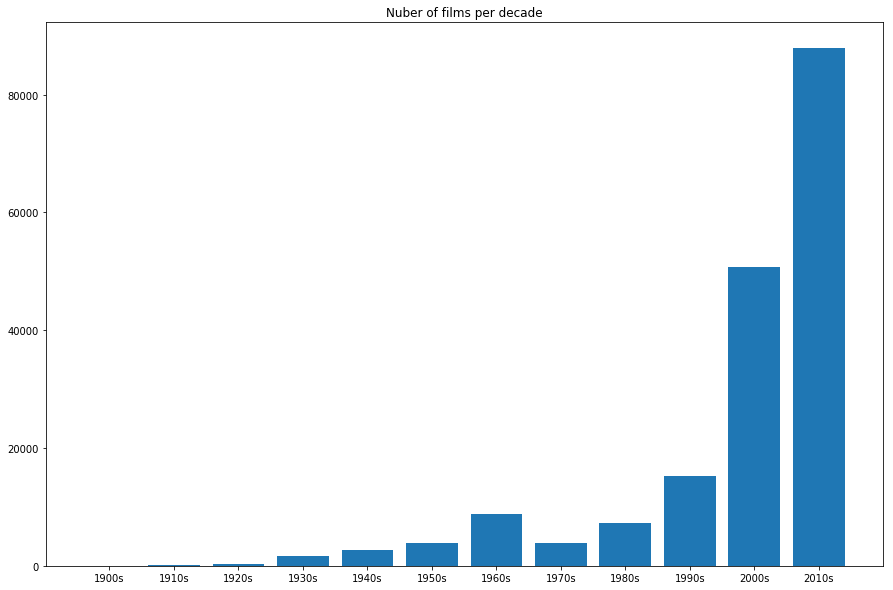

In [9]:
plt.figure(figsize=(15,10))
plt.bar(labels, counts)
plt.title('Nuber of films per decade')
plt.show()

As expected, we have more films in the recent decades.